# Data Wrangling and EDA - Amazon Rainforest Image Classification
Capstone Project 2 - Connor McAnuff


## Contents:
- Module Importing
- Data Importing
- Image Tags Exploration and Visualization
- Image Samples
- Pixel Histograms
- Mean Images
- Clustering

In [3]:
%load_ext watermark

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark


In [4]:
%watermark -a "Connor McAnuff" -d -t -v -p numpy,pandas

Connor McAnuff 2019-10-23 18:45:51 

CPython 3.7.4
IPython 7.8.0

numpy 1.17.3
pandas 0.25.2


In [5]:
# Auto reload modules marked with "%aimport"
# Use a line %aimport [module to be imported]
%load_ext autoreload
%autoreload 1

## Module Importing

In [6]:
import numpy as np 
import pandas as pd
import os
import gc
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

pal = sns.color_palette()

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import cv2
from tqdm import tqdm_notebook as tqdm

PROJ_ROOT = os.path.join(os.pardir)

print(os.path.abspath(PROJ_ROOT))

C:\Users\conno\Documents\Springboard\Projects\Springboard-Projects\capstone-2


## Data Importing

In [7]:
# Get the file/directory sizes
print('# File sizes')
for f in os.listdir(PROJ_ROOT + '/data/raw/'):
    if not os.path.isdir(PROJ_ROOT + '/data/raw/' + f):
        print(f.ljust(30) + str(round(os.path.getsize(PROJ_ROOT + '/data/raw/' + f) / 1000000, 2)) + 'MB')
    else:
        sizes = [os.path.getsize(PROJ_ROOT + '/data/raw/'+f+'/'+x)/1000000 for x in os.listdir(PROJ_ROOT + '/data/raw/' + f)]
        print(f.ljust(30) + str(round(sum(sizes), 2)) + 'MB' + ' ({} files)'.format(len(sizes)))

# File sizes
.gitkeep                      0.0MB
test_v2_file_mapping.csv      0.61MB
train-jpg                     634.68MB (40480 files)
train-tif-v2                  21234.96MB (40479 files)
train-tif-v2.tar              21264.11MB
train_v2.csv                  1.43MB


In [8]:
# Set paths to data

jpg_image_path = str(os.path.join(PROJ_ROOT,
                            'data',
                            'raw',
                             'train-jpg')
                            + '\\{}' + '.jpg')

tif_image_path = str(os.path.join(PROJ_ROOT,
                            'data',
                            'raw',
                             'train-tif-v2')
                            + '\\{}' + '.tif')

image_tags_path = os.path.join(PROJ_ROOT,
                            'data',
                            'raw',
                             'train_v2.csv')

## Image Tags Exploration and Visualization
Partially adapted from: https://www.kaggle.com/anokas/data-exploration-analysis

In [9]:
# Train_v2.csv is an array containing a list of the images and their tags
df = pd.read_csv(image_tags_path)
print('Total of {} images'.format(len(df)))
df.head()

Total of 40479 images


,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [10]:
# Create a series of tags, each observation split into multiple strings
tags = df['tags'].apply(lambda x: x.split(' '))

# Create a list of all occuring, non-unique tags
all_tags = [item for sublist in list(df['tags'].apply(lambda row: row.split(" ")).values) for item in sublist]

all_tags[:10]

['haze',
 'primary',
 'agriculture',
 'clear',
 'primary',
 'water',
 'clear',
 'primary',
 'clear',
 'primary']

In [11]:
print('total of {} non-unique tags in all training images'.format(len(all_tags)))
print('average number of tags per image {}'.format(1.0*len(all_tags)/df.shape[0]))

total of 116278 non-unique tags in all training images
average number of tags per image 2.8725511993873365


In [12]:
# Calculate the number of occurences of each tag 
tags_counted_and_sorted = pd.DataFrame({'tag': all_tags}).groupby('tag').size().reset_index().sort_values(0, ascending=False).reset_index(drop=True)
tags_counted_and_sorted.columns = ['tag', 'count']

tags_counted_and_sorted

,tag,count
0,primary,37513
1,clear,28431
2,agriculture,12315
3,road,8071
4,water,7411
5,partly_cloudy,7261
6,cultivation,4547
7,habitation,3660
8,haze,2697
9,cloudy,2089


In [13]:
# Use a defaultdict to pass information to plotly
from collections import Counter, defaultdict
counts = defaultdict(int)
for l in tags:
    for l2 in l:
        counts[l2] += 1

data=[go.Bar(x=list(counts.keys()), y=list(counts.values()))]
layout=dict(height=800, width=800, title='Distribution of training tags')
fig=dict(data=data, layout=layout)
py.iplot(data, filename='train-tag-dist')

- Almost all images are tagged with primary
- The assumed most important tags have very few occurences compared to other tags:
    - slash_burn (209)
    - artisinal_mine (339)
    - selective logging (selective_logging)

In [14]:
# Co-occurence Matrix
com = np.zeros([len(counts)]*2)
for i, l in enumerate(list(counts.keys())):
    for i2, l2 in enumerate(list(counts.keys())):
        c = 0
        cy = 0
        for row in tags.values:
            if l in row:
                c += 1
                if l2 in row: cy += 1
        com[i, i2] = cy / c

data=[go.Heatmap(z=com, x=list(counts.keys()), y=list(counts.keys()))]
layout=go.Layout(height=800, width=800, title='Co-occurence matrix of training tags')
fig=dict(data=data, layout=layout)
py.iplot(data, filename='train-com')

For each tag on the y-axis, the co-occurence matrix gives the fraction of images with that tag that also have each tag on the x-axis. For example, images tagged with blow_down are also tagged with haze 0% of the time, are also tagged with primary 100% of the time, and are also tagged with agriculture 22.4% of the time. 

- Most tags have a 1.0 or near 1.0 co-occurence value with primary
- cloudy has a 0.0 co-occurence value with all other tags

# Image Samples

The images are given in both jpeg and tiff format. The jpeg images were converted from the tiff images and therefore some sort of loss of detail / accuracy is expected. The tiff images include 4 channels - Red, Green, Blue, and Near-Infrared. They therefore cannot be viewed to see true colour unless the near-infrared channel is removed. 

In [15]:
# Function to fetch a tif or jpg image given its tag
def get_image(tag, form):
    """Use opencv to read and return an image given its tag and form.
    tag must by in string format e.g. 'train_0' and form must be 'jpg' or 'tif'."""
    
    # If jpg, read in
    if form == 'jpg':
        img = cv2.imread(jpg_image_path.format(tag))
        
    # If tif, read in using cv2 flag IMREAD_UNCHANGED    
    elif form == 'tif':
        img = cv2.imread(tif_image_path.format(tag), flags=cv2.IMREAD_UNCHANGED)
        
    # Otherwise, print message    
    else:
        print('Image format must be jpg or tif')
    
    return img

# Function to show an image
def show_image(img):
    """Plot an image. If image is a jpg, a regular image is plotted.
    If image is a tif, the intensity of RGB and Near-Infrared are plotted separately.
    The tif images are therefore not showing true color, rather intensity of each channel."""
    
    # If image is a jpg, plot using imshow after converting BGR to RGB
    if img.shape == (256,256,3):
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    
    # Else, if image is a tif, plot the intensity of 4 channels separately
    elif img.shape == (256,256,4):
        
        channels = cv2.split(img)
        
        f, ax = plt.subplots(1,4, figsize=(18,4))
        
        ax[0].imshow(channels[0], cmap='nipy_spectral')
        ax[1].imshow(channels[1], cmap='nipy_spectral')
        ax[2].imshow(channels[2], cmap='nipy_spectral')
        ax[3].imshow(channels[3], cmap='nipy_spectral')
        
        ax[0].set_title('Blue Intensity')
        ax[1].set_title('Green Intensity')
        ax[2].set_title('Red Intensity')
        ax[3].set_title('Near Infrared Intensity')
    
    # Otherwise, print this message
    else:
        print('Please input a valid jpg or tif image')
    
    plt.show()

jpeg image train_10


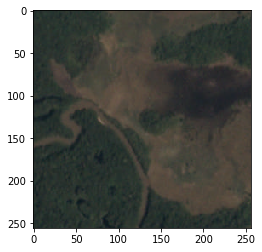

tif image channel intensities train_10


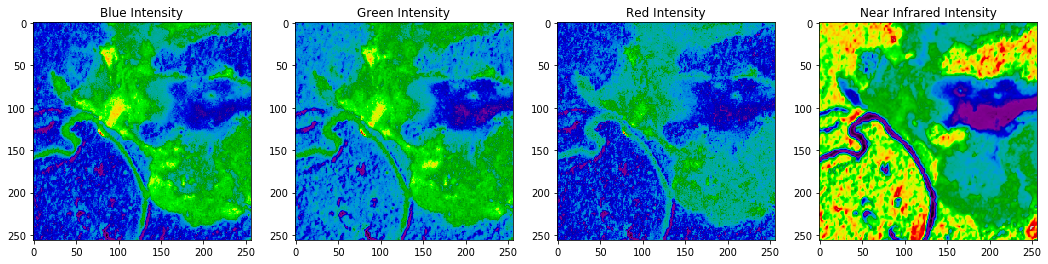

In [16]:
print('jpeg image train_10')
show_image(get_image('train_10', 'jpg'))
print('tif image channel intensities train_10')
show_image(get_image('train_10', 'tif'))

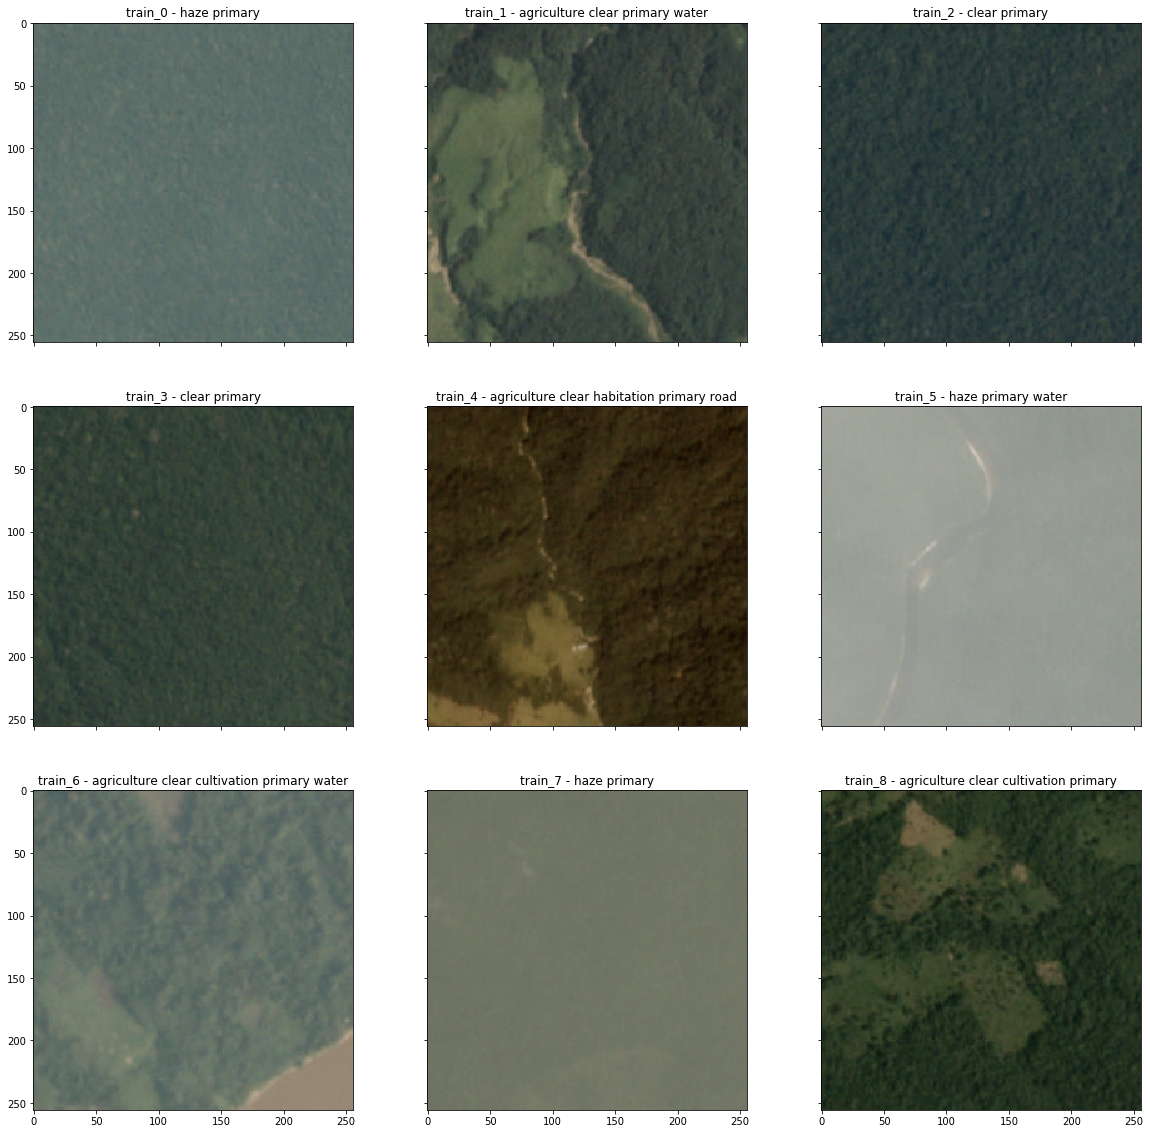

In [17]:
# Plot 9 images for viewing

new_style = {'grid': False}
plt.rc('axes', **new_style)
_, ax = plt.subplots(3, 3, sharex='col', sharey='row', figsize=(20, 20))

i = 0
for f, l in df[:9].values:
    
    img = cv2.imread(jpg_image_path.format(f))
    ax[i // 3, i % 3].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax[i // 3, i % 3].set_title('{} - {}'.format(f, l))
    i += 1
    
plt.show()

# Pixel histograms

- Work in progress - underdetermined how this information will be used.

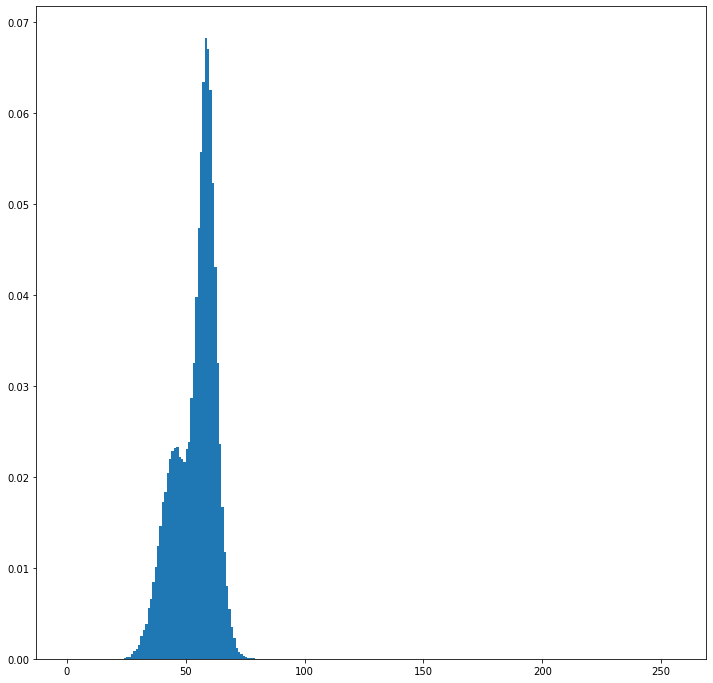

In [18]:
f, ax = plt.subplots(figsize=(12,12))

plt.hist(get_image('train_2', 'jpg').flatten(), bins=256, range=(0, 256), density=True)
plt.show()

# Mean Images

The mean of a set of images can be calculated simply by averaging the RGB values of each pixel. Here, we aim to compare the mean image of the set of images containing each class.

In [19]:
# Function to calculate the mean RGB of each pixel for a set of images
def calc_image_mean(images_list):
    """Input a list of images (list or pandas series form) and return
    the mean RGB value for each pixel location (average R-G-B = total R-G-B / # of images)."""
    
    # Initialize mean image with zeros
    mean_image = np.zeros((256, 256, 3))
    
    # For each image in the image list, get the image and add it to mean image
    for image in images_list:
        mean_image = mean_image + get_image(image, 'jpg')
    
    # Divide the mean image by the number of images
    mean_image = mean_image / len(images_list)
    
    # Return the mean image with values rounded and converted to integers
    return np.round(mean_image).astype('uint8')

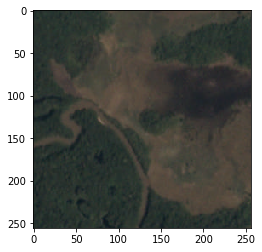

In [20]:
# Testing the image mean function
mean_image_test = calc_image_mean(df['image_name'].iloc[10:11])
show_image(mean_image_test)
plt.show()

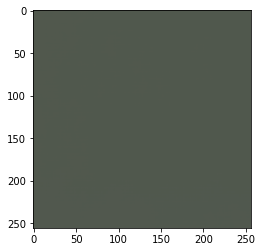

In [21]:
# Calculate the mean image for all images
mean_image_all = calc_image_mean(df['image_name'])
show_image(mean_image_all)

In [22]:
# Calculate the mean image for each tag

mean_image_dict = {}

for tag in tqdm(tags_counted_and_sorted['tag']):

    images_list = df[df['tags'].str.contains(tag)]['image_name']
    
    if tag == 'cloudy':
        images_list = df[df['tags'].str.contains(tag)]
        images_list = images_list[~images_list['tags'].str.contains('partly_cloudy')]['image_name']
    
    print(tag)
    print(len(images_list))
    
    mean_image = calc_image_mean(images_list)
        
    mean_image_dict['mean_image_' + str(tag)] = mean_image

primary
37513
clear
28431
agriculture
12315
road
8071
water
7411
partly_cloudy
7261
cultivation
4477
habitation
3660
haze
2697
cloudy
2089
bare_ground
862
selective_logging
340
artisinal_mine
339
blooming
332
slash_burn
209
blow_down
98
conventional_mine
100



In [38]:
import pickle

# Save the mean_image_dict for later so process does not need to be re-run 
pickle_out = open("data/processed/mean_image_dict_pickle.pkl","wb")
pickle.dump(mean_image_dict,pickle_out)
pickle_out.close()

FileNotFoundError: [Errno 2] No such file or directory: 'data/processed/mean_image_dict_pickle.pkl'

In [ ]:
# Test loading from pickle file
pickle_in = open("data/processed/mean_image_dict_pickle.pkl","rb")
mean_image_dict_pkl = pickle.load(pickle_in)

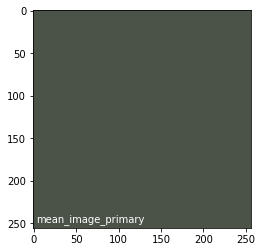

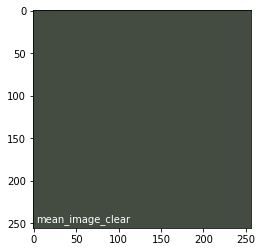

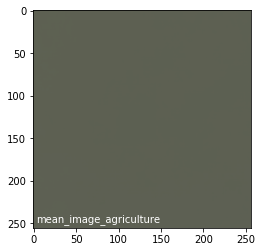

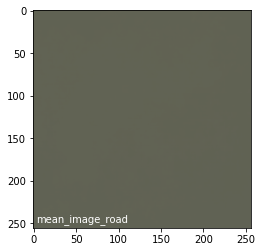

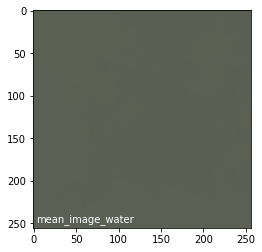

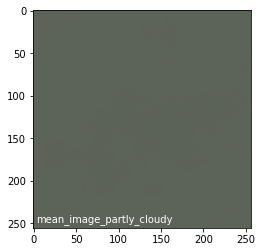

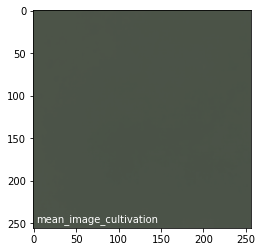

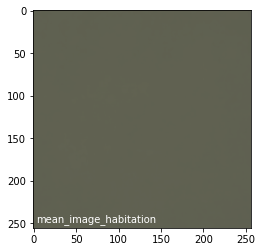

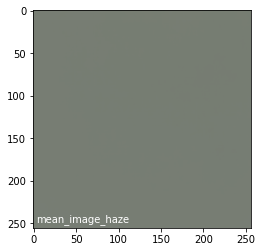

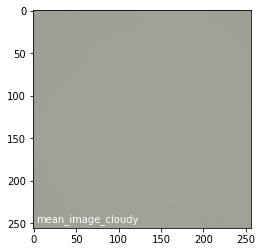

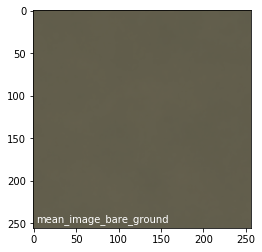

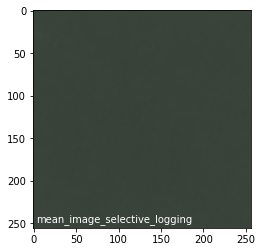

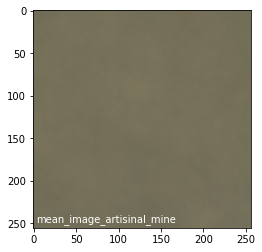

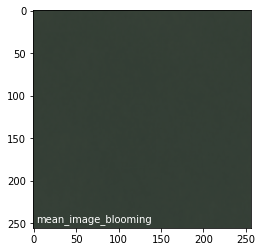

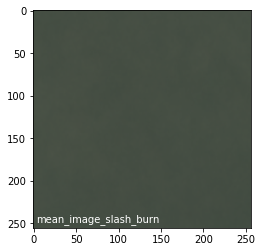

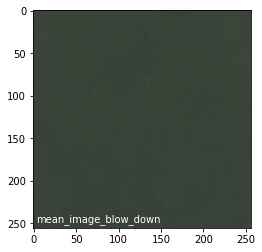

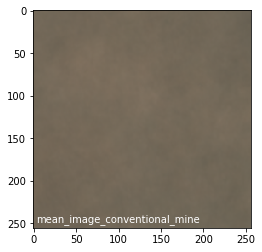

In [23]:
for key, value in mean_image_dict.items():
    plt.imshow(cv2.cvtColor(value, cv2.COLOR_BGR2RGB))
    plt.annotate(key, xy=(3,248), c='w')
    plt.show()

## Clustering

### Colours within an image
Resource: https://stackoverflow.com/questions/43111029/how-to-find-the-average-colour-of-an-image-in-python-with-opencv

First, let's use kmeans clustering to find the dominant colours of an image.

In [24]:
def single_image_mean(image):
    
    single_image = get_image(image, 'jpg')
    single_image_mean = single_image.mean(axis=0).mean(axis=0).round(0).astype('uint8')
    single_image_full = np.ones(shape=single_image.shape, dtype=np.uint8)*single_image_mean
    
    return single_image_full

Original Image


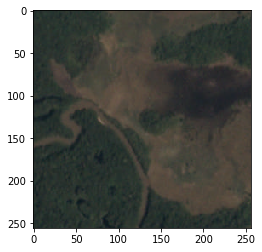

Image Mean Colour


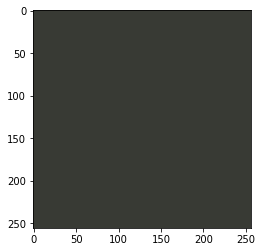

In [25]:
train_10_mean = single_image_mean('train_10')
print('Original Image')
show_image(get_image('train_10', 'jpg'))
print('Image Mean Colour')
show_image(train_10_mean)

### Calculate dominant colours in single image

In [26]:
def get_dominant_colors(image, n_colors=5):

    pixels = np.float32(image.reshape(-1, 3))

    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 200, .1)
    flags = cv2.KMEANS_RANDOM_CENTERS

    _, labels, palette = cv2.kmeans(pixels, n_colors, None, criteria, 10, flags)
    _, counts = np.unique(labels, return_counts=True)

    #dominant_pallete = palette[np.argmax(counts)]

    indices = np.argsort(counts)[::-1]   
    freqs = np.cumsum(np.hstack([[0], counts[indices]/counts.sum()]))
    rows = np.int_(img.shape[0]*freqs)

    dominant_pallete_image = np.zeros(shape=image.shape)
    for i in range(len(rows) - 1):
        dominant_pallete_image[rows[i]:rows[i + 1], :, :] += palette[indices[i]]

    return dominant_pallete_image.round(0).astype('uint8')


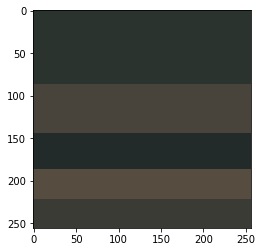

In [27]:
train_10_dom_colors = get_dominant_colors(get_image('train_10', 'jpg'), n_colors=5)
show_image(train_10_dom_colors)

### Image clusters
- Let's take a step back from clustering colours in single images and take a look at clustering the images themselves. We'll start with 1000 randomly selected images.
- The plan is to (eventually) compare the image clusters with their associated tags.

In [28]:
from sklearn.manifold import TSNE
from scipy.spatial.distance import pdist, squareform
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

In [29]:
# Function to get the image matrix for all images 
def get_images_mat(image_names):

    all_imgs = []

    for image_name in tqdm(image_names):
        img = get_image(image_name, 'jpg')
        img = cv2.normalize(img, None, 0.0, 1.0, cv2.NORM_MINMAX)
        img = img.reshape(1, -1)
        all_imgs.append(img)

    img_mat = np.vstack(all_imgs)

    return img_mat

In [30]:
def imscatter(tsne, images_list, ax=None, zoom=0.2):
    
    assert len(tsne) == len(images_list)
    
    n_imgs=len(tsne)
    
    x = tsne[0:n_imgs,0]
    y = tsne[0:n_imgs,1]
    images = [get_image(images_list.iloc[i], 'jpg') for i in range(n_imgs)]
    
    plt.figure(figsize=(20,20))
    ax = plt.gca()
    images = [OffsetImage(image, zoom=zoom) for image in images]
    artists = []
    for x0, y0, im0 in zip(x, y, images):
        ab = AnnotationBbox(im0, (x0, y0), xycoords='data', frameon=False)
        artists.append(ax.add_artist(ab))
    ax.update_datalim(np.column_stack([x, y]))
    ax.autoscale()

In [31]:
all_images_sample = df.sample(1000, random_state=42)

In [32]:
img_mat = get_images_mat(all_images_sample['image_name'])

In [33]:
tsne = TSNE(
    n_components=2,
    perplexity=30,
    init='random', # pca?
    random_state=42,
    method='barnes_hut',
    n_iter=1000,
    learning_rate=200,
    verbose=1
).fit_transform(img_mat)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 18.290s...
[t-SNE] Computed neighbors for 1000 samples in 365.193s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 22.344650
[t-SNE] KL divergence after 250 iterations with early exaggeration: 106.479019
[t-SNE] KL divergence after 1000 iterations: 1.310345


In [39]:
# Save the tsne for later so process does not need to be re-run 
pickle_out = open(PROJ_ROOT + "/data/processed/tsne_1000_samples.pkl","wb")
pickle.dump(tsne,pickle_out)
pickle_out.close()

In [40]:
# Test loading from pickle file
pickle_in = open(PROJ_ROOT + "/data/processed/tsne_1000_samples.pkl","rb")
tsne_1000_samples_pkl = pickle.load(pickle_in)

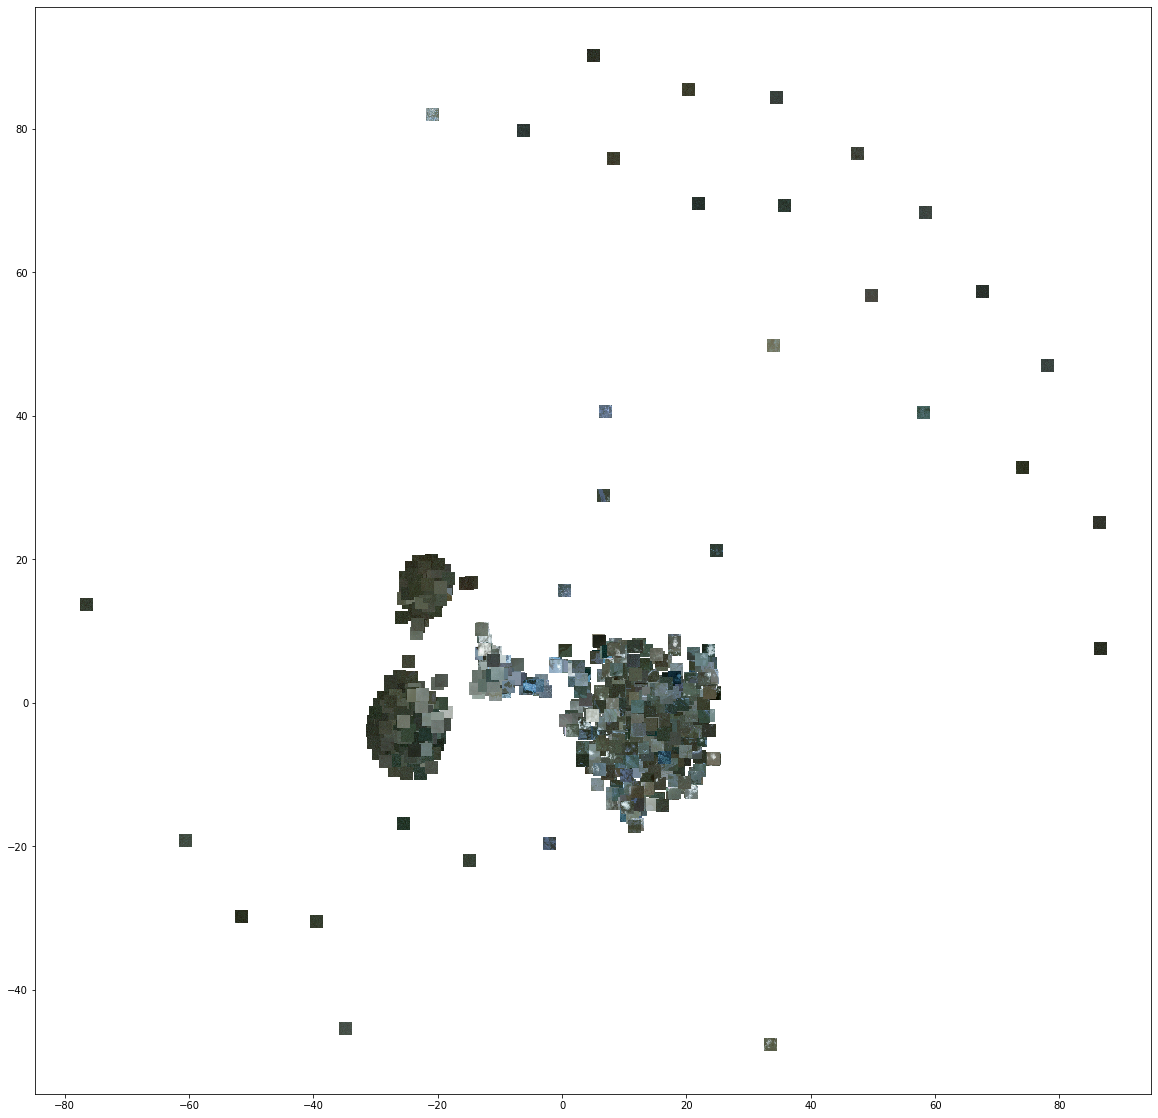

In [44]:
imscatter(tsne=tsne, images_list=all_images_sample['image_name'], zoom=0.05)

- Next, let's select only the images with most rare tags

In [91]:
def get_image_list_by_tag(images, *tags):
    
    for tag in tags:
    
        images_list = df[df['tags'].str.contains(tag)]['image_name']
    
        if tag == 'cloudy':
            images_list = df[df['tags'].str.contains(tag)]
            images_list = images_list[~images_list['tags'].str.contains('partly_cloudy')]['image_name']
        
    #image_list_df = df.image_name[[images_list]]

    return images_list

In [92]:
rare_tag_image_list = pd.Series()

for tag in tqdm(tags_counted_and_sorted['tag'][-7:]):
    
    temp_images_list = get_image_list_by_tag(df['image_name'], tag)
    
    rare_tag_image_list = rare_tag_image_list.append(temp_images_list)

In [93]:

img_mat_select = get_images_mat(rare_tag_image_list)

In [94]:
tsne_select = TSNE(
    n_components=2,
    perplexity=30,
    init='random', # pca?
    random_state=42,
    method='barnes_hut',
    n_iter=1000,
    learning_rate=200,
    verbose=1
).fit_transform(img_mat_select)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2280 samples in 51.788s...
[t-SNE] Computed neighbors for 2280 samples in 1775.330s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2280
[t-SNE] Computed conditional probabilities for sample 2000 / 2280
[t-SNE] Computed conditional probabilities for sample 2280 / 2280
[t-SNE] Mean sigma: 13.935220
[t-SNE] KL divergence after 250 iterations with early exaggeration: 116.397705
[t-SNE] KL divergence after 1000 iterations: 1.709763


In [95]:
# Save the tsne for later so process does not need to be re-run 
pickle_out = open(PROJ_ROOT + "/data/processed/tsne_rare_samples.pkl","wb")
pickle.dump(tsne,pickle_out)
pickle_out.close()

In [96]:
# Test loading from pickle file
pickle_in = open(PROJ_ROOT + "/data/processed/tsne_rare_samples.pkl","rb")
tsne_rare_samples_pkl = pickle.load(pickle_in)

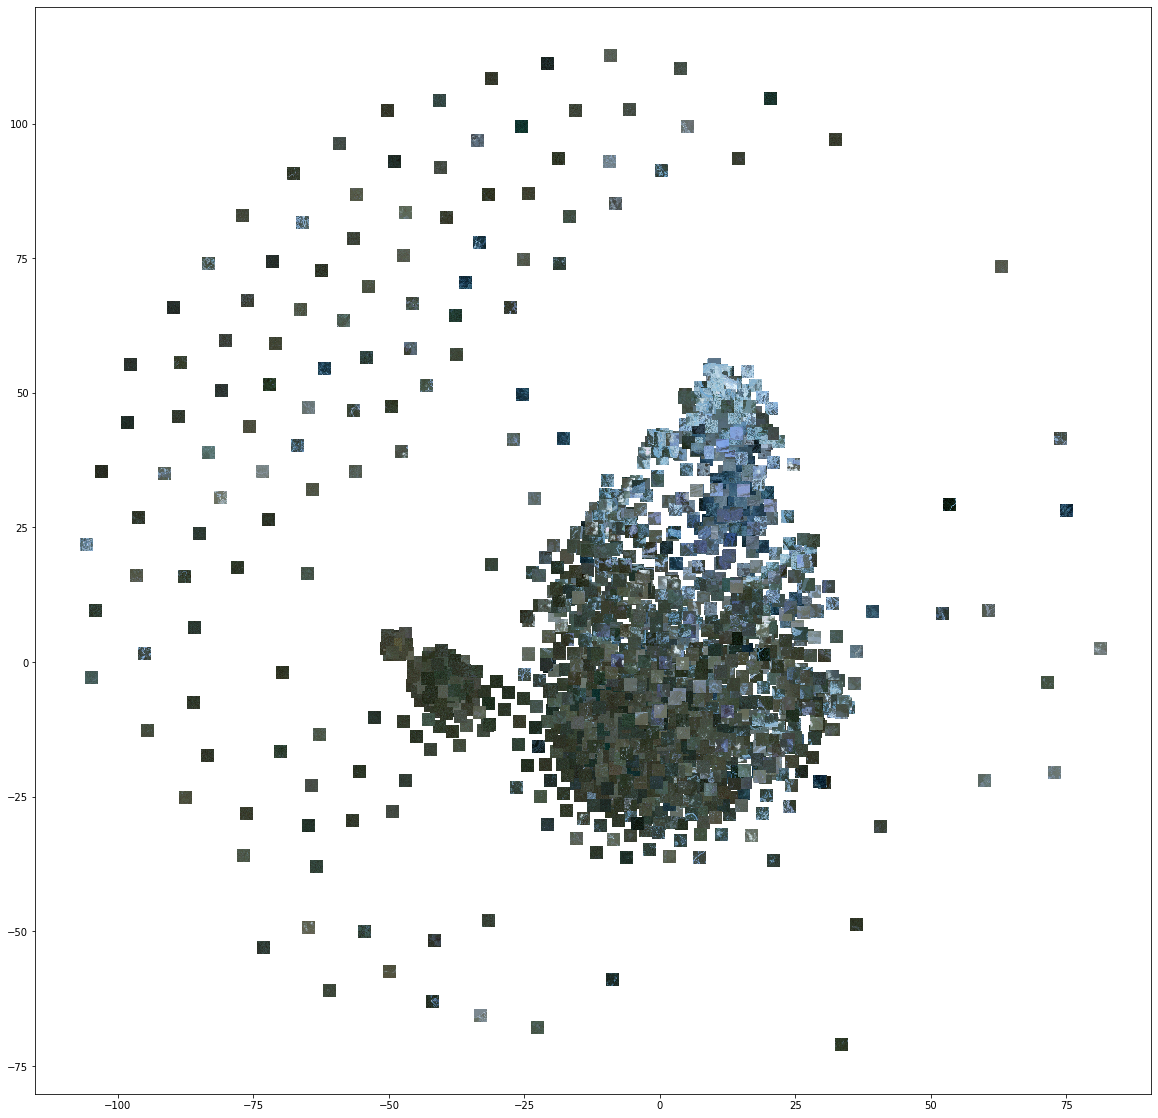

In [97]:
imscatter(tsne=tsne_select, images_list=rare_tag_image_list, zoom=0.05)